In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np 
import pandas as pd 
import os
import scanpy as sc 

import sys
sys.path.append('../src')

In [11]:
# # JING TUMOR
# name = 'jing_tumor'
# n_pcs = 16
# model_name = f'esm2_pca{n_pcs}'
# y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/tumor_y2.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/0.05_0.5_out'
# y = pd.read_csv(y_path)['y'].values
# sequences = pd.read_csv('/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/filtered_x2_cdr3_b.csv')['cdr3_b']

# # CLONAL EXPANSION
# name = 'jing_clonal_expansion'
# n_pcs = 16
# model_name = f'esm2_pca{n_pcs}'
# y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
# y = pd.read_csv(y_path)['Y'].values
# sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_betaseqs_raw.csv', index_col=0)

# # CONGA c2_gex_donor1
# name = 'conga_c2_gex_donor1'
# n_pcs = 16
# model_name = f'esm2_pca{n_pcs}'
# y_path = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/inputs/10x_200k_donor1_y.csv'
# slide_outs = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/outputs/10x_200k_donor1/0.01_0.5_out'
# barcodes = pd.read_csv(y_path).index
# y = pd.read_csv(y_path)['is_c2'].values
# adata = sc.read_h5ad('/ix3/djishnu/alw399/SLIDE_PLM/data/conga/toJishnu/10x_200k_donor1.h5ad')
# sequences = adata[barcodes, :].obs['cdr3b']

# CONGA mait donor1
name = 'conga_mait_donor1'
n_pcs = 16
model_name = f'esm2_pca{n_pcs}'
y_path = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/inputs/10x_200k_donor1_mait_y.csv'
slide_outs = '/ix3/djishnu/alw399/SLIDE_PLM/data/slide/outputs/10x_200k_donor1_mait/0.01_0.5_out'
barcodes = pd.read_csv(y_path).index
y = pd.read_csv(y_path)['is_mait'].values
adata = sc.read_h5ad('/ix3/djishnu/alw399/SLIDE_PLM/data/conga/toJishnu/10x_200k_donor1.h5ad')
sequences = adata[barcodes, :].obs['cdr3b']
# sequences = adata[barcodes, :].obs['cdr3a']



/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [12]:
from util import get_sigLFs

z1s = get_sigLFs(slide_outs)
z_matrix = pd.read_csv(os.path.join(slide_outs, 'z_matrix.csv'), index_col=0)
z_matrix = z_matrix[z1s]
z_matrix.shape

(1109, 36)

In [13]:
# Interactors did not contribute to signal
# z_matrix = pd.DataFrame(z_matrix['Z7'])
# z_matrix = pd.DataFrame(z_matrix['Z15', 'Z16'])
# z_matrix = pd.DataFrame(z_matrix['Z79'])

In [14]:
from util import remove_empty_tcrs

sequences, y, z_matrix = remove_empty_tcrs(sequences, y, z_matrix)
sequences.shape, y.shape, z_matrix.shape

((1109,), (1109,), (1109, 36))

### Get embeddings

In [15]:
from esm2.Run_ESM2 import * 

data = load_model()
model, alphabet, batch_converter = data

In [16]:
batch_labels = sequences.astype(str)
seq_str_list = sequences.astype(str)
raw_batch = list(zip(batch_labels, seq_str_list))

embeddings = get_representations(raw_batch, model, alphabet, batch_converter )
embeddings.shape

(1109, 1280)

In [17]:
np.save(f'/ix/djishnu/alw399/SLIDE_PLM/data/esm2_embeddings/{name}.npy', embeddings)


### Load embeddings

In [18]:
# embeddings = np.load(f'../data/esm2_embeddings/{name}.npy')
print(name)
embeddings = np.load(f'/ix/djishnu/alw399/SLIDE_PLM/data/esm2_embeddings/{name}.npy')
embeddings.shape

conga_mait_donor1


(1109, 1280)

In [19]:
from sklearn.decomposition import PCA

model = PCA(n_components=n_pcs)
model.fit(embeddings)
tcr_embeddings = model.transform(embeddings)
tcr_embeddings.shape

(1109, 16)

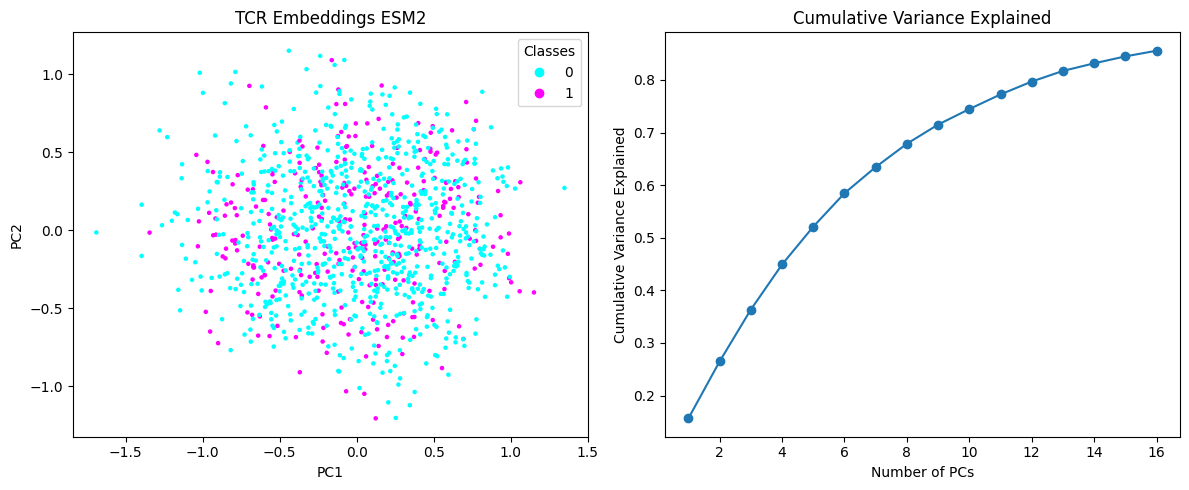

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
scatter = ax[0].scatter(tcr_embeddings[:, 0], tcr_embeddings[:, 1], c=y, cmap='cool', s=5)
legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].set_title('TCR Embeddings ESM2')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

# Cumulative variance explained plot
cumsum_variance = np.cumsum(model.explained_variance_ratio_)
ax[1].plot(range(1, n_pcs+1), cumsum_variance, marker='o')
ax[1].set_title('Cumulative Variance Explained')
ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('Cumulative Variance Explained')

plt.tight_layout()
os.makedirs(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}', exist_ok=True)
plt.savefig(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_pca.png')
plt.show()


In [24]:
from interaction import Interaction

machop = Interaction(
    slide_outs, 
    plm_embed=tcr_embeddings, 
    y=y,
    z_matrix=z_matrix,
    interacts_only=False,
    model='LR'
)

machop.get_sig_interactions(fdr=0.6, n_iters=20, thresh=0.65)

Found 1 significant interactions with AUC=0.7198503236245954


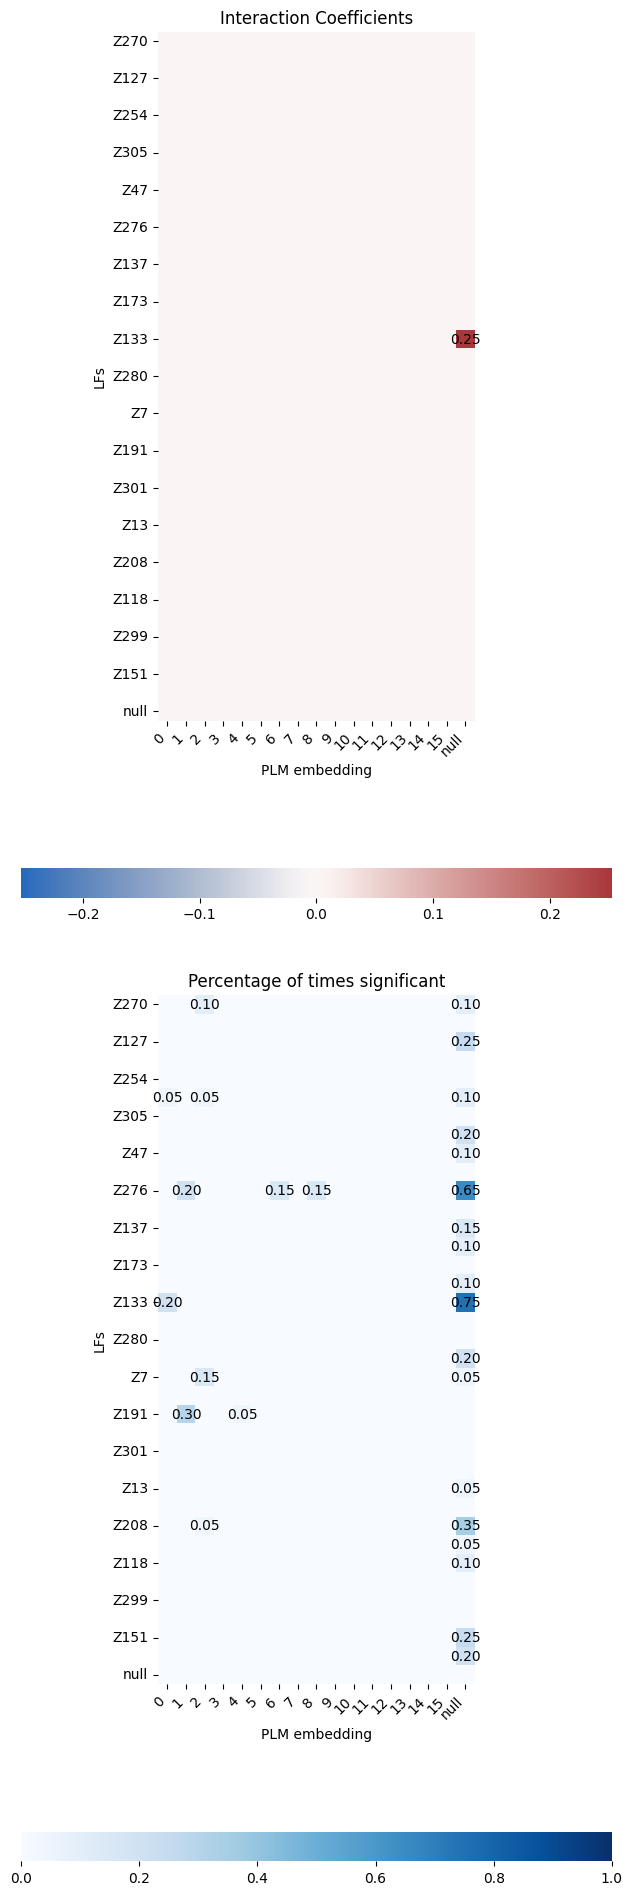

In [ ]:
from plotting import show_interactions
show_interactions(machop, save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_betas.png')

In [26]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(1109, 1)

In [27]:
thresh = machop.params['thresh']
fdr = machop.params['fdr']
n_iters = machop.params['n_iters']

np.save(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_joint_embed_fdr{fdr}_iters{n_iters}_thresh_{thresh}.npy', joint_embed)

In [28]:
full_embed = np.hstack([machop.z_matrix, machop.plm_embedding])
full_embed.shape

(1109, 54)

In [29]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

In [30]:
model = LinearRegression()

estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)
auc1 = estimator.evaluate(full_embed, y)
auc2 = estimator.evaluate(machop.z_matrix, y)
auc3 = estimator.evaluate(machop.plm_embedding, y)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

full vs. joint: Kruskal-Wallis independent samples (pairwise between groups), P_val:2.569e-02 Stat=4.977e+00
joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
joint vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:6.502e-03 Stat=7.406e+00


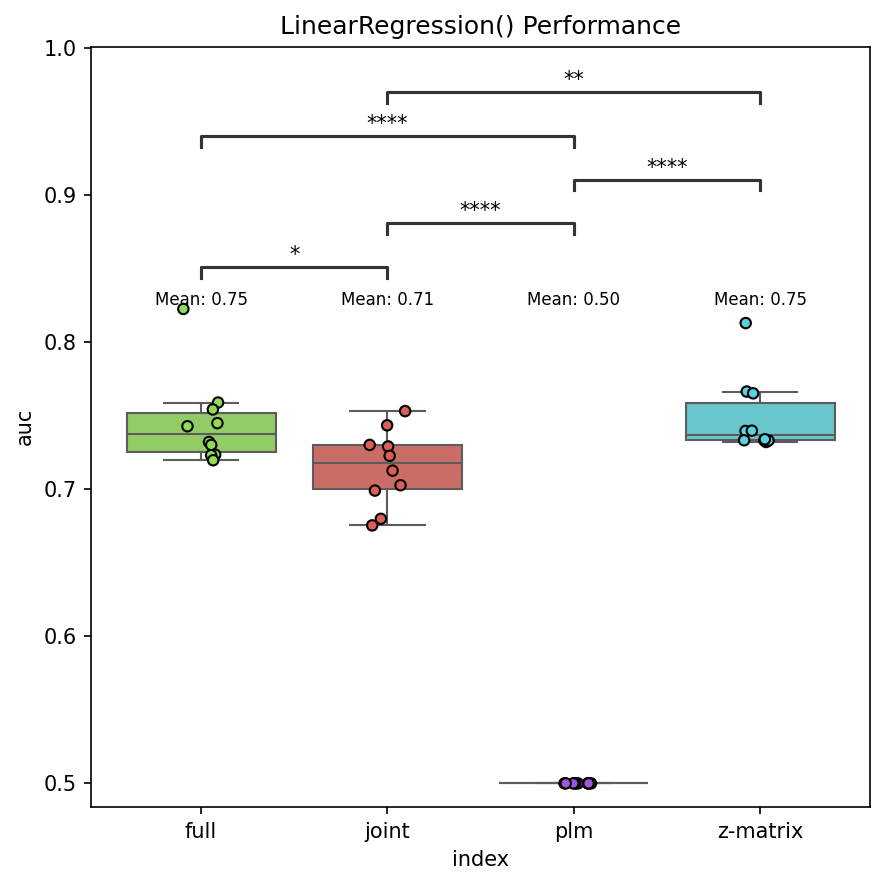

In [31]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

from plotting import show_performance
show_performance(model, df, 
                 save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_{model.__class__.__name__}_performance.png')

In [ ]:
model = Lasso(alpha=0.02)

estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)
auc1 = estimator.evaluate(full_embed, y)
auc2 = estimator.evaluate(machop.z_matrix, y)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [ ]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

In [ ]:
show_performance(model, df, 
                 save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_{model.__class__.__name__}_performance.png')

In [ ]:
# joint_path = f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_joint_embed.npy'
# joint_embed = np.load(joint_path)
# joint_embed.shape

In [ ]:
import matplotlib.pyplot as plt

n_plots = (joint_embed.shape[1] + 1) // 2
n_rows = (n_plots + 2 - 1) // 2 

fig, axs = plt.subplots(2, n_rows, figsize=(4, n_rows * 4)) 
axs = axs.flatten()

for i in range(0, joint_embed.shape[1], 2):
    dim1 = joint_embed[:, i]
    dim2 = joint_embed[:, i+1] if i+1 < joint_embed.shape[1] else joint_embed[:, i-1] 
    
    axs[i//2].scatter(dim1, dim2, c=y, alpha=0.5, cmap='coolwarm', s=2)
    axs[i//2].set_xlabel(f'joint embed {i}')
    axs[i//2].set_ylabel(f'joint embed {i+1}' if i+1 < joint_embed.shape[1] else f'joint embed {i-1}')

plt.suptitle('Separation of classes using joint embedding from ESM2 model', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()
